# Library Import

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [88]:
#폴더 경로를 설정해줍니다.
os.chdir('../1. open') 

In [89]:
#제공된 데이터들의 리스트를 확인합니다.
os.listdir()

['sample_submission.csv',
 'test_imgs',
 'test_imgs.zip',
 'train_df.csv',
 'train_imgs',
 'train_imgs.zip']

# 데이터 불러오고 살펴보기 

In [90]:
train = pd.read_csv('train_df.csv')
submission = pd.read_csv('sample_submission.csv')

train.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.000000,...,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.59369,1041.422997,331.694815,1065.593682,...,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445


In [91]:
train.shape

(4195, 49)

In [92]:
#submission 파일 불러오기
submission.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,649-2-4-32-Z148_A-0000003.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
#glob를 활용해 이미지의 경로들을 불러옵니다.
import glob
train_paths = glob.glob('./train_imgs/*.jpg')
test_paths = glob.glob('./test_imgs/*.jpg')
print(len(train_paths), len(test_paths))

4195 1600


# 시각화

주어진 이미지와 keypoint지점을 비교해보며 데이터에 대한 이해도를 높여봐요!

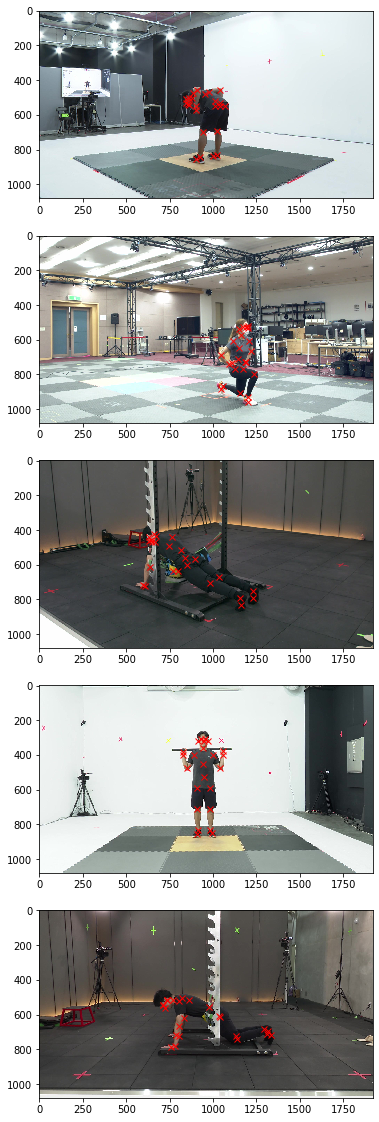

In [94]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1


# 모델링

In [95]:
train['path'] = train_paths

대용량 이미지를 불러올 때 Generator 를 활용해서 불러옵니다.

In [96]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)

#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [97]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [98]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))

In [99]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [100]:
model.fit(train_dataset,epochs = 5, verbose=1)

Epoch 1/5
132/132 [==============================] - 1004s 8s/step - loss: 37087.0195 - mae: 133.6983
Epoch 2/5
132/132 [==============================] - 1021s 8s/step - loss: 15870.0273 - mae: 95.3402
Epoch 3/5
132/132 [==============================] - 1006s 8s/step - loss: 14896.9971 - mae: 91.9001
Epoch 4/5
132/132 [==============================] - 984s 7s/step - loss: 12081.7217 - mae: 83.3200
Epoch 5/5
132/132 [==============================] - 1016s 8s/step - loss: 12769.1729 - mae: 86.1234


# test 데이터

In [101]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:24<00:00, 65.62it/s]


In [102]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([1600, 180, 320, 3])

In [103]:
pred=model.predict(X_test)

# 제출하기

In [104]:
submission.iloc[:,1:]=pred

In [105]:
submission

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1268.942261,501.726440,1269.619629,580.965881,1265.062378,624.053589,1217.318604,660.389771,1257.067871,...,1191.721313,404.613220,1041.095459,548.207947,936.469849,537.801331,617.804443,690.768799,739.869690,698.975952
1,649-2-4-32-Z148_A-0000003.jpg,1266.402710,501.665619,1267.430908,580.004089,1263.021973,623.521729,1215.314087,659.858765,1254.967285,...,1189.480713,404.449280,1039.838257,547.744080,934.701416,536.664978,616.171570,689.491333,738.628479,697.600586
2,649-2-4-32-Z148_A-0000005.jpg,1304.076538,516.678101,1307.529785,596.015076,1307.690796,642.814575,1253.189331,675.316284,1293.296387,...,1238.987549,427.304077,1068.822998,572.099670,960.351807,548.463318,627.232971,696.583008,754.906311,699.582397
3,649-2-4-32-Z148_A-0000007.jpg,1303.540894,566.759033,1281.081787,655.217590,1295.017212,695.655518,1234.407227,721.599670,1276.489868,...,1235.773193,461.448059,1085.823120,589.895630,971.152893,573.485840,638.403870,721.482605,751.492981,714.414673
4,649-2-4-32-Z148_A-0000009.jpg,1329.686890,544.586121,1336.249023,619.779053,1344.486450,661.792114,1278.710815,687.482056,1320.781006,...,1270.250977,465.981079,1092.786987,597.718994,976.056091,566.775330,624.912231,706.950073,739.894470,701.431213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,999.335327,552.011169,868.791809,633.477356,910.661011,659.839722,901.270142,649.869629,979.360352,...,1018.104919,535.420532,1044.843384,669.874817,1113.969971,805.077698,1199.465576,860.448975,1399.939575,903.735718
1596,786-3-5-41-Z94_E-0000025.jpg,1106.906128,562.054382,958.990662,666.396912,991.827515,681.334534,989.851257,672.662354,1068.646851,...,1085.259033,551.748901,1115.356567,691.800232,1181.441895,847.740662,1257.530273,876.744995,1466.704224,899.254395
1597,786-3-5-41-Z94_E-0000027.jpg,993.554016,536.595947,867.835388,619.877747,905.165161,643.348877,899.118774,637.044128,976.804688,...,1009.601868,515.173706,1037.880005,657.589050,1106.484253,790.974976,1193.503052,844.256287,1391.666748,883.414673
1598,786-3-5-41-Z94_E-0000029.jpg,1061.924683,557.271851,922.531799,657.576782,956.912903,671.012268,951.458862,663.424255,1032.706543,...,1045.470703,550.322205,1085.036499,689.566223,1154.308716,833.558472,1235.957642,872.923462,1441.200928,897.152222


In [106]:
submission.to_csv('baseline_submission.csv', index=False)